# Pullback Strategy Research Notebook

In [1]:
import pandas as pd, numpy as np
import sys, os

sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Scripts'))
from indicators import *
from parameters import *
from func import *
from ohlcv import *

# Suppresses SettingWithCopyWarning in Pandas
pd.options.mode.chained_assignment = None  # default='warn'

## Getting OHLC data

In [2]:
# ohlcv = collectOHLCV('EUR_USD', start=time_before_now(weeks=52), 
#                      granularity='M1')
# ohlcv.to_csv('../ohlc/EURUSD_{}_{}.csv'.format(str(ohlcv.index[0]).split(' ')[0],
#                                                str(ohlcv.index[-1]).split(' ')[0]))

In [2]:
ohlcv = pd.read_csv('../ohlc/EURUSDM1test.csv', 
                    index_col='time')

In [3]:
#ohlcv = ohlcv + 0.00007 # for duka only

In [4]:
# Parameter Overrides
Pip_Diff_SL = 5
risk = 3

In [28]:
halfspr = 0.00007

# Indicator setup
indic = pd.DataFrame()

indic['Don_S_H'] = Donchian_H(ohlcv.high, Don_SX)
indic['Don_S_L'] = Donchian_L(ohlcv.low, Don_SX)
indic['Don_L_H'] = Donchian_H(ohlcv.high, Don_S)
indic['Don_L_L'] = Donchian_L(ohlcv.low, Don_S)
indic['Don_H_M'] = (lambda x, y: (x+y)/2)(
    Donchian_H(ohlcv.high, Don_L),
    Donchian_L(ohlcv.low, Don_L)
)

indic['MACD_Hist'] = MACD_Hist(ohlcv.close, *MACD_param)
indic['SMA_Diff']  = MA_Cross(ohlcv.close, SMA_Fast, SMA_Slow)

indic['Buy_Chan']  = indic.Don_L_L > indic.Don_H_M
indic['Sell_Chan'] = indic.Don_L_H < indic.Don_H_M


 #+--------------------------------------+

# Long Signal
longSig = pd.DataFrame(index=ohlcv.index)

longSig['Stop'] = np.where(indic.MACD_Hist.shift(1) < 0,
                           indic.Don_L_H.shift(1) + Pip_Diff*0.0001, 
                           None)
longSig['Stop'].fillna(method='ffill', inplace = True)

longSig['Sig'] = np.where((ohlcv.high + halfspr) > longSig.Stop, 1, 0)
longSig['Sig'] = np.where(longSig.Stop > ohlcv.open, longSig.Sig, 0)
longSig['Sig'] = np.where(indic.SMA_Diff.shift(1) > 0, longSig.Sig, 0)
longSig['Sig'] = np.where(indic.Buy_Chan.shift(1), longSig.Sig, 0)

longSig['InitialSL'] = indic.Don_S_L.shift(1) - Pip_Diff_SL*0.0001
longSig['InitialSL'] = np.where((longSig.Stop - longSig.InitialSL) > Pip_Diff_SL*0.0001,
                                 longSig.InitialSL, longSig.Stop - Pip_Diff_SL*0.0001)

# MACD Pullback region
longSig['macd'] = np.where((indic.MACD_Hist.shift(2) > 0) & (indic.MACD_Hist.shift(1) < 0), 1, 0)
longSig['macd'] = longSig['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
longSig.loc[longSig.Sig == 0, 'Sig'] = None

# longSig['Sig'] = np.where(longSig['macd'].shift(1) == longSig['macd'], 
#                           np.where(longSig['Sig'].shift(1) == 1,None, longSig['Sig']),
#                          np.where(longSig['Sig'] == 1,
#                                  longSig['Sig'], 0))

longSig['Sig'] = np.where(longSig['macd'].shift(1) == longSig['macd'], 
                          np.where(longSig['Sig'].shift(1) == 1,None, longSig['Sig']), 0)


longSig['Sig'].fillna(method='ffill', inplace=True)

#longSig['Sig'] = np.where(longSig['Sig'].shift(1) + longSig['Sig'] == 2 ,0, longSig['Sig'])
longSig['Sig'] = np.where((longSig['Sig'] == 1) & (longSig['macd'].shift(1) == longSig['macd']), 
                          np.where(longSig['Sig'].shift(1) + longSig['Sig'] == 2 ,0, longSig['Sig']), 0)




longSig['SigPrice'] = np.where(longSig.Sig == 1, longSig.Stop, 0)

longSig['StopLoss'] = np.where((ohlcv.low + halfspr) < longSig.InitialSL,
                               longSig.InitialSL, None)
longSig['StopLoss'].fillna(method='bfill', inplace=True)


longSig['Closed'] = np.where(longSig.StopLoss == None, False, True)

# Replaced Close Price to current InitialSL
longSig['StopLoss'].fillna(value=longSig.InitialSL.iloc[-1], inplace=True)
longSig['StopLoss'] = np.where(longSig.InitialSL > longSig.StopLoss,
                               longSig.InitialSL,  longSig.StopLoss)

# Trade Duration
longSig['SLtime'] = pd.to_datetime(
    np.where((ohlcv.low + halfspr) < longSig.InitialSL, longSig.index, None)
)
longSig['SLtime'].fillna(method='bfill', inplace=True)
longSig['SLtime'].fillna(value=longSig.index[-1], inplace=True)
longSig['SLtime'] = np.where(longSig.InitialSL > longSig.StopLoss,
                             longSig.index,  longSig.SLtime)
#+--------------------------------------+

# Short Signal
shortSig = pd.DataFrame(index=ohlcv.index)

shortSig['Stop'] = np.where(indic.MACD_Hist.shift(1) > 0,
                            indic.Don_L_L.shift(1) - Pip_Diff*0.0001, None)
shortSig['Stop'].fillna(method='ffill', inplace = True)

shortSig['Sig'] = np.where((ohlcv.low - halfspr) < shortSig.Stop, 1, 0)
shortSig['Sig'] = np.where(shortSig.Stop < ohlcv.open, shortSig.Sig, 0)

shortSig['Sig'] = np.where(indic.SMA_Diff.shift(1) < 0, shortSig.Sig, 0)
shortSig['Sig'] = np.where(indic.Sell_Chan.shift(1), shortSig.Sig, 0)

shortSig['InitialSL'] = indic.Don_S_H.shift(1) + Pip_Diff_SL*0.0001
shortSig['InitialSL'] = np.where((shortSig.InitialSL - shortSig.Stop) > Pip_Diff_SL*0.0001,
                                 shortSig.InitialSL, shortSig.Stop + Pip_Diff_SL*0.0001)


# MACD Pullback region
shortSig['macd'] = np.where((indic.MACD_Hist.shift(2) < 0) & (indic.MACD_Hist.shift(1) > 0), 1, 0) # this is the same as longsig macd condi
shortSig['macd'] = shortSig['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
shortSig.loc[shortSig.Sig == 0, 'Sig'] = None

# shortSig['Sig'] = np.where(shortSig['macd'].shift(1) == shortSig['macd'], 
#                            np.where(shortSig['Sig'].shift(1) == 1,None, shortSig['Sig']), 
#                            np.where(shortSig['Sig'] == 1,
#                                  shortSig['Sig'], 0))
shortSig['Sig'] = np.where(shortSig['macd'].shift(1) == shortSig['macd'], 
                           np.where(shortSig['Sig'].shift(1) == 1,None, shortSig['Sig']), 0)

shortSig['Sig'].fillna(method='ffill', inplace=True)

#shortSig['Sig'] = np.where(shortSig['Sig'].shift(1) + shortSig['Sig'] == 2,0, shortSig['Sig'])
shortSig['Sig'] = np.where((shortSig['Sig'] == 1) & (shortSig['macd'].shift(1) == shortSig['macd']), 
                           np.where(shortSig['Sig'].shift(1) + shortSig['Sig'] == 2,0, shortSig['Sig']), 0)

shortSig['SigPrice'] = np.where(shortSig.Sig == 1, shortSig.Stop, 0)

shortSig['StopLoss'] = np.where((ohlcv.high - halfspr) > shortSig.InitialSL,
                               shortSig.InitialSL, None)
shortSig['StopLoss'].fillna(method='bfill', inplace=True)

shortSig['Closed'] = np.where(shortSig.StopLoss == None, False, True)

# Replaced Close Price to current InitialSL
shortSig['StopLoss'].fillna(value=shortSig.InitialSL.iloc[-1], inplace=True)
shortSig['StopLoss'] = np.where(shortSig.InitialSL < shortSig.StopLoss,
                                shortSig.InitialSL,  shortSig.StopLoss)

# Trade Duration
shortSig['SLtime'] = pd.to_datetime(
    np.where((ohlcv.high - halfspr) > shortSig.InitialSL, shortSig.index, None)
)
shortSig['SLtime'].fillna(method='bfill', inplace=True)
shortSig['SLtime'].fillna(value=shortSig.index[-1], inplace=True)
shortSig['SLtime'] = np.where(shortSig.InitialSL < shortSig.StopLoss,
                                shortSig.index,  shortSig.SLtime)
#+--------------------------------------+

# Strategy
strat = pd.DataFrame(index=ohlcv.index)

strat['Sig'] = np.where(longSig.Sig,
                        longSig.Sig,
                        np.where(shortSig.Sig,
                                 shortSig.Sig, 0))

strat['Units'] = np.where(longSig.Sig,
                          (risk/(longSig.SigPrice - \
                                 longSig.InitialSL)),
                          0)
strat['Units'] = np.where(shortSig.Sig,
                          (risk/(shortSig.SigPrice - \
                                 shortSig.InitialSL)),
                          strat.Units)
strat['Units'] = strat.Units.astype(np.int)

strat['SigPrice'] = np.where(longSig.Sig, longSig.SigPrice,
                             np.where(shortSig.Sig, shortSig.SigPrice,
                                      0))
strat['StopLoss'] = np.where(longSig.Sig, longSig.StopLoss,
                             np.where(shortSig.Sig, shortSig.StopLoss,
                                      0))
strat['InitialSL'] = np.where(longSig.Sig, longSig.InitialSL,
                             np.where(shortSig.Sig, shortSig.InitialSL,
                                      0))

strat['BuyProfits'] = np.where(
    longSig.Sig,
    (longSig.StopLoss - longSig.SigPrice)*strat.Units, 0
)
strat['SellProfits'] = np.where(
    shortSig.Sig,
    (shortSig.StopLoss - shortSig.SigPrice)*strat.Units, 0
)
strat['Profits'] = strat.BuyProfits + strat.SellProfits

strat['Closed'] = np.where(longSig.Sig, longSig.Closed,
                           np.where(shortSig.Sig, shortSig.Closed,
                                    None))
strat.loc[longSig.Sig == True, 
          'SLtime'] = longSig.loc[longSig.Sig == True, 
                                  'SLtime']
strat.loc[shortSig.Sig == True, 
          'SLtime'] = shortSig.loc[shortSig.Sig == True,
                                   'SLtime']

strat = strat[(strat.Sig == 1)]
print('We have populated {} simulated trades.'.format(strat.shape[0]))


We have populated 64 simulated trades.


In [27]:
strat[-30:]

Sig  Units  SigPrice  StopLoss  InitialSL  BuyProfits  \
time                                                                         
2018-08-06 15:27:00  1.0   2083   1.15670   1.16066    1.15526     8.24868   
2018-08-07 06:56:00  1.0   2097   1.15822   1.16066    1.15679     5.11668   
2018-08-07 08:39:00  1.0   2097   1.15870   1.16066    1.15727     4.11012   
2018-08-07 10:51:00  1.0   2586   1.15963   1.16066    1.15847     2.66358   
2018-08-07 10:57:00  1.0   2290   1.16008   1.16066    1.15877     1.32820   
2018-08-08 01:37:00  1.0   2307   1.16078   1.16066    1.15948    -0.27684   
2018-08-08 03:05:00  1.0   2127   1.16137   1.16066    1.15996    -1.51017   
2018-08-08 04:12:00  1.0   2631   1.16246   1.16132    1.16132    -2.99934   
2018-08-08 11:54:00  1.0  -2068   1.15845   1.14544    1.15990     0.00000   
2018-08-08 12:37:00  1.0  -2238   1.15780   1.14544    1.15914     0.00000   
2018-08-08 17:58:00  1.0   2459   1.16104   1.16015    1.15982    -2.18851   
2018-08-09 07:05:00  1.0  -1714   1.15933   1.14544    1.16108     0.00000   
2018-08-09 07:34:00  1.0  -1935   1.15794   1.14544    1.15949     0.00000   
2018-08-09 14:30:00  1.0  -1973   1.15822   1.14544    1.15974     0.00000   
2018-08-09 14:57:00  1.0  -2158   1.15724   1.14544    1.15863     0.00000   
2018-08-09 15:52:00  1.0  -1734   1.15614   1.14544    1.15787     0.00000   
2018-08-09 17:04:00  1.0  -2205   1.15508   1.14544    1.15644     0.00000   
2018-08-09 18:21:00  1.0  -2654   1.15493   1.14544    1.15606     0.00000   
2018-08-09 18:57:00  1.0  -2238   1.15444   1.14544    1.15578     0.00000   
2018-08-09 19:44:00  1.0  -2097   1.15287   1.14544    1.15430     0.00000   
2018-08-09 22:41:00  1.0  -2500   1.15224   1.14544    1.15344     0.00000   
2018-08-10 05:09:00  1.0  -1923   1.15108   1.14544    1.15264     0.00000   
2018-08-10 08:23:00  1.0  -1530   1.14486   1.14317    1.14682     0.00000   
2018-08-10 09:58:00  1.0  -1562   1.14572   1.14317    1.14764     0.00000   
2018-08-10 11:00:00  1.0  -2142   1.14612   1.14317    1.14752     0.00000   
2018-08-10 11:29:00  1.0  -1570   1.14560   1.14317    1.14751     0.00000   
2018-08-10 12:13:00  1.0  -2631   1.14514   1.14317    1.14628     0.00000   
2018-08-10 13:14:00  1.0  -1530   1.14344   1.14317    1.14540     0.00000   
2018-08-10 15:13:00  1.0  -1694   1.14175   1.14256    1.14352     0.00000   
2018-08-10 15:51:00  1.0  -2173   1.14078   1.14216    1.14216     0.00000   

                     SellProfits   Profits Closed              SLtime  
time                                                                   
2018-08-06 15:27:00      0.00000   8.24868   True 2018-08-08 07:58:00  
2018-08-07 06:56:00      0.00000   5.11668   True 2018-08-08 07:58:00  
2018-08-07 08:39:00      0.00000   4.11012   True 2018-08-08 07:58:00  
2018-08-07 10:51:00      0.00000   2.66358   True 2018-08-08 07:58:00  
2018-08-07 10:57:00      0.00000   1.32820   True 2018-08-08 07:58:00  
2018-08-08 01:37:00      0.00000  -0.27684   True 2018-08-08 07:58:00  
2018-08-08 03:05:00      0.00000  -1.51017   True 2018-08-08 07:58:00  
2018-08-08 04:12:00      0.00000  -2.99934   True 2018-08-08 07:58:00  
2018-08-08 11:54:00     26.90468  26.90468   True 2018-08-10 06:22:00  
2018-08-08 12:37:00     27.66168  27.66168   True 2018-08-10 06:22:00  
2018-08-08 17:58:00      0.00000  -2.18851   True 2018-08-09 14:57:00  
2018-08-09 07:05:00     23.80746  23.80746   True 2018-08-10 06:22:00  
2018-08-09 07:34:00     24.18750  24.18750   True 2018-08-10 06:22:00  
2018-08-09 14:30:00     25.21494  25.21494   True 2018-08-10 06:22:00  
2018-08-09 14:57:00     25.46440  25.46440   True 2018-08-10 06:22:00  
2018-08-09 15:52:00     18.55380  18.55380   True 2018-08-10 06:22:00  
2018-08-09 17:04:00     21.25620  21.25620   True 2018-08-10 06:22:00  
2018-08-09 18:21:00     25.18646  25.18646   True 2018-08-10 06:22:00  
2018-08-09 18:57:00     20.14200  20.14200   True 2018-08-10 06:22:00  
2018-08-09 1

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

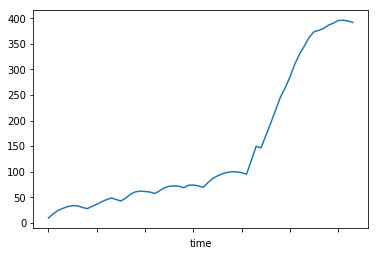

In [20]:
plt.figure()
(strat['Profits']).cumsum().plot()

In [21]:
#Annual return
annualReturn = (strat.Profits).cumsum().iloc[-1]/8/10
print('Annual returns: {}%'.format(annualReturn))
#Max absolute DD
absoluteDD = Drawdown((strat.Profits).cumsum()).max()/10
print('DD: {}%'.format(absoluteDD))
#MAR
MAR = annualReturn/absoluteDD
print('MAR: {}'.format(MAR))

Annual returns: 4.89834862500019%
DD: 0.5999619999999254%
MAR: 8.16443145566019


In [22]:
#strat.to_csv('../Results/BasicEURUSDH1.csv')

In [23]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



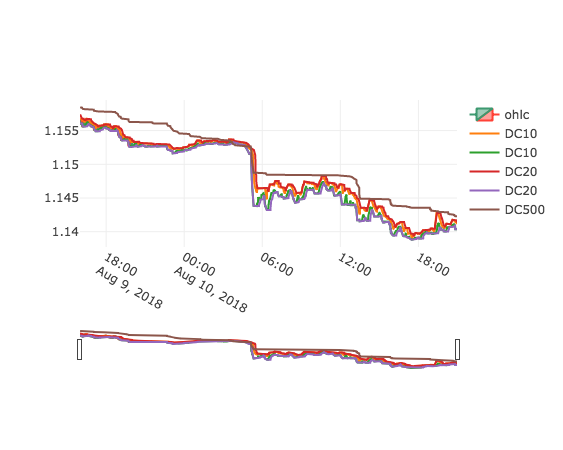

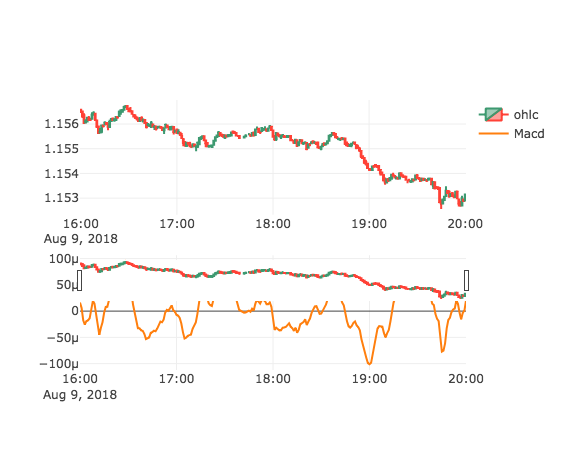

In [25]:
a = "2018-08-09 16:00:00"
b = "2018-08-09 20:00:00"

trace0 = go.Candlestick(x = ohlcv[a:b].index,
                      open = ohlcv[a:b].open,
                      high = ohlcv[a:b].high,
                      low = ohlcv[a:b].low,
                      close = ohlcv[a:b].close,
                       name = 'ohlc')

# trace1 = go.Scatter(x = ohlcv[a:b].index,
#                    y = longSig[a:b].InitialSL,
#                    name = 'LongSigSL')
# trace2 = go.Scatter(x = ohlcv[a:b].index,
#                    y = shortSig[a:b].InitialSL,
#                    name = 'ShortSigSL')
# trace3 = go.Scatter(x = ohlcv[a:b].index,
#                    y = longSig[a:b].Stop,
#                    name = 'LongSigStop')
# trace4 = go.Scatter(x = ohlcv[a:b].index,
#                    y = longSig[a:b].Stop,
#                    name = 'ShortSigStop')
# trace5 = go.Scatter(x = ohlcv[a:b].index,
#                    y = indic[a:b].Don_H_M,
#                    name = 'DC500')

trace1 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_S_H,
                   name = 'DC10')
trace2 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_S_L,
                   name = 'DC10')
trace3 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_L_H,
                   name = 'DC20')
trace4 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_L_L,
                   name = 'DC20')
trace5 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_H_M,
                   name = 'DC500')


data = [trace0, trace1, trace2, trace3, trace4, trace5]


trace6 = go.Scatter(x = ohlcv[a:b].index,
                   y = indic[a:b].MACD_Hist,
                   name = 'Macd')


fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace6, 2, 1)

py.iplot(data, filename='DC')
py.iplot(fig, filename='Candlestick')
